# Welcome To The Notebook

### Task 1 - Set up the project environment

In [2]:
!pip install openai==1.55.3 python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.7.2
    Uninstalling openai-1.7.2:
      Successfully uninstalled openai-1.7.2


Importing modules

In [3]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

OpenAI API is ready.


Creating OpenAI Client

In [ ]:
client = OpenAI(
  api_key="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
)
print("OpenAI API is ready.")

### Task 2 - Prepare the training data

Loading the provided `Customer Complaints.csv`



In [6]:
training_data = pd.read_csv("/content/files/Customer Complaints.csv")
training_data.head()

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."
3,Ridiculous prices for such terrible service! ...,"{""Topic"": ""Billing"", ""Problem"": ""Overcharged"",..."
4,Internet speed slower than a snail! Can't str...,"{""Topic"": ""Internet"", ""Problem"": ""Slow speed"",..."


**Converting the Complaints records to json**

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>

Let's get started!

Let's define a method that get's a row of the dataframe and convert it into the json format

In [7]:
def save_as_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Now let's use of this method to generate the `training_data.json`

In [8]:
for index, row in training_data.iterrows():
  save_as_json(row)

### Task 3 - Fine-tune GPT 3.5 based on our training data

Let's import the json file we prepared as our training data

In [9]:
data_file = client.files.create(
  file=open("/content/training_data.json", "rb"),
  purpose='fine-tune'
)

Create the Fine Tuning Job

In [11]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=data_file.id,
    model="gpt-3.5-turbo",
    hyperparameters={
        "n_epochs": 1
    }
)

Let's retrieve the state of the fine-tune

In [15]:
retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)


In [60]:
print(retrieved_job.status)

running


### Task 4 - Evaluate model

Let's retrieve the event messages to check out the learning process of our fine-tuning job.

In [61]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieved_job.id, limit=50)

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-EPQcuQPYki3agniDcRCsgcmB', created_at=1734730604, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-as34fIJRf804LNy3JdG8flRq', created_at=1734730599, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-cNuf8Bjr090UAC5HgFpf6CZh', created_at=1734730561, level='info', message='Step 67/67: training loss=0.08', object='fine_tuning.job.event', data={'step': 67, 'train_loss': 0.08156128227710724, 'total_steps': 67, 'train_mean_token_accuracy': 1.0}, type='metrics'), FineTuningJobEvent(id='ftevent-nVljlLkXX2iWLsj1ZyrtXiSL', created_at=1734730559, level='info', message='Step 66/67: training loss=0.11', object='fine_tuning.job.event', data={'step': 66, 'train_loss': 0.11035133898258209, 'total_steps': 67, 'train_mean_token_accuracy': 0.96

Let's extract the training loss in each learning step

In [62]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieved_job.id, limit=10).data)
for event in events:
  print(event.data)

{}
{}
{'step': 67, 'train_loss': 0.08156128227710724, 'total_steps': 67, 'train_mean_token_accuracy': 1.0}
{'step': 66, 'train_loss': 0.11035133898258209, 'total_steps': 67, 'train_mean_token_accuracy': 0.9615384340286255}
{'step': 65, 'train_loss': 0.10022823512554169, 'total_steps': 67, 'train_mean_token_accuracy': 0.9230769276618958}
{'step': 64, 'train_loss': 0.05356895551085472, 'total_steps': 67, 'train_mean_token_accuracy': 1.0}
{'step': 63, 'train_loss': 0.03980347141623497, 'total_steps': 67, 'train_mean_token_accuracy': 1.0}
{'step': 62, 'train_loss': 0.04019276797771454, 'total_steps': 67, 'train_mean_token_accuracy': 1.0}
{'step': 61, 'train_loss': 0.055199284106492996, 'total_steps': 67, 'train_mean_token_accuracy': 1.0}
{'step': 60, 'train_loss': 0.10248268395662308, 'total_steps': 67, 'train_mean_token_accuracy': 0.9599999785423279}


Use a line chart to visualize the train_loss in each step

In [33]:
from json.encoder import py_encode_basestring
steps = []
train_losses = []
for e in events:
  try:
    steps.append(e.data["step"])
    train_losses.append(e.data["train_loss"])
  except:
    pass

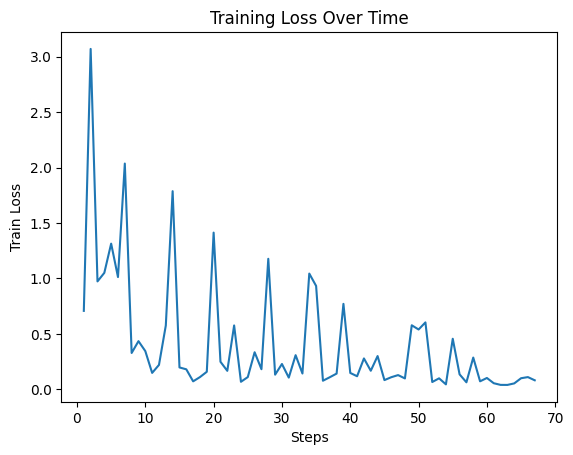

In [34]:
plt.plot(steps, train_losses)
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.title("Training Loss Over Time")
plt.show()

### Task 5 - Deploy our model

Let's take a look at `retrieved_job` again

In [59]:
retrieved_job

FineTuningJob(id='ftjob-hjxZx5B9W3TCO554jiQRKKnE', created_at=1734730302, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-Vk2oQtIAJwUn5YK7CARQCz7L', result_files=[], seed=1015553830, status='running', trained_tokens=None, training_file='file-M11szJkoT5yL2LiwPPxm7X', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None, method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 1, 'batch_size': 1, 'learning_rate_multiplier': 2.0}}})

Defining a method to extract information from a given user complaint using a specific LLM and return the results.

In [39]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


Let's use our fine-tuned model to extract the details for the following user complaint:

*TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!*

In [42]:
complaint = "TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!"


'{\n  "Topic": "TV Subscription",\n  "Problem": "Channels disappearing from subscription",\n  "Customer_Dissatisfaction_Index": "High"\n}'

Let's test our `GPT-4` model with the same user complaint

In [ ]:
extract_details(complaint, "gpt-4")

Let's try for the following complaint:

*Line is down! It is really annoying!*

Now let's compare the results from GPT-4

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.

In [ ]:
customer_complaint = "I am very Angry! I want my money back!"